# **Import Libraries ⬇**

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, SimpleRNN, Dropout
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from google.colab import drive
import tensorflow as tf
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
import string
import re
from keras.callbacks import EarlyStopping

In [2]:
device_name = tf.test.gpu_device_name()
if len(device_name) > 0:
    print("Found GPU at: {}".format(device_name))
else:
    device_name = "/device:CPU:0"
    print("No GPU, using {}.".format(device_name))

Found GPU at: /device:GPU:0


In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


# **Load data**

In [4]:
# Load the dataset
df = pd.read_csv("/content/drive/MyDrive/IMDB Dataset.csv")
print(df.head())

                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive


# **Data Preproccessing**

In [5]:
X = df['review'].astype(str)
y = df['sentiment']

In [6]:
print("Length of X:", len(X))
print("Length of y:", len(y))

Length of X: 50000
Length of y: 50000


In [7]:
X

0        One of the other reviewers has mentioned that ...
1        A wonderful little production. <br /><br />The...
2        I thought this was a wonderful way to spend ti...
3        Basically there's a family where a little boy ...
4        Petter Mattei's "Love in the Time of Money" is...
                               ...                        
49995    I thought this movie did a down right good job...
49996    Bad plot, bad dialogue, bad acting, idiotic di...
49997    I am a Catholic taught in parochial elementary...
49998    I'm going to have to disagree with the previou...
49999    No one expects the Star Trek movies to be high...
Name: review, Length: 50000, dtype: object

In [8]:
y

0        positive
1        positive
2        positive
3        negative
4        positive
           ...   
49995    positive
49996    negative
49997    negative
49998    negative
49999    negative
Name: sentiment, Length: 50000, dtype: object

In [9]:
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('english'))
# Load NLTK WordNet for lemmatization
nltk.download('wordnet')
# Create instances for lemmatization and stemming
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [10]:
def preprocess_text(text):
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove non-word characters and special characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Lowercasing
    text = text.lower()
    # Tokenize the data
    tokens = word_tokenize(text)
    # Remove stop words
    tokens = [token for token in tokens if token not in stop_words]
    # Apply lemmatization and stemming
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    tokens = [stemmer.stem(token) for token in tokens]
    # Join tokens back into a string
    preprocessed_text = ' '.join(tokens)
    return preprocessed_text

In [11]:
Xp = X.apply(preprocess_text)

In [12]:
Xp

0        one review mention watch oz episod youll hook ...
1        wonder littl product film techniqu unassum old...
2        thought wonder way spend time hot summer weeke...
3        basic there famili littl boy jake think there ...
4        petter mattei love time money visual stun film...
                               ...                        
49995    thought movi right good job wasnt creativ orig...
49996    bad plot bad dialogu bad act idiot direct anno...
49997    cathol taught parochi elementari school nun ta...
49998    im go disagre previou comment side maltin one ...
49999    one expect star trek movi high art fan expect ...
Name: review, Length: 50000, dtype: object

In [13]:
print("Length of X:", len(X))
print("Length of y:", len(y))

Length of X: 50000
Length of y: 50000


In [14]:
# Tokenize the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(Xp)
Xp_sequences = tokenizer.texts_to_sequences(Xp)

# Pad sequences to ensure uniform length
max_sequence_length = max([len(seq) for seq in Xp_sequences])
Xp_pad = pad_sequences(Xp_sequences, maxlen=max_sequence_length)

In [15]:
Xp_pad

array([[    0,     0,     0, ...,   448,  3350,   387],
       [    0,     0,     0, ...,   278,    20,   153],
       [    0,     0,     0, ...,    16,    10,   128],
       ...,
       [    0,     0,     0, ...,  3267, 16177,  1063],
       [    0,     0,     0, ...,  1799,  1437,   321],
       [    0,     0,     0, ...,   911,   611,     1]], dtype=int32)

In [16]:
# Encode the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [17]:
y_encoded

array([1, 1, 1, ..., 0, 0, 0])

In [18]:
print("Length of X:", len(Xp_pad))
print("Length of y:", len(y_encoded))

Length of X: 50000
Length of y: 50000


# **Split Data**

In [19]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(Xp_pad, y_encoded, test_size=0.2, random_state=42)

# **Modeling**

In [20]:
def build_rnn_model(input_dim, output_dim, input_length):
    model = Sequential()
    model.add(Embedding(input_dim=input_dim, output_dim=output_dim))
    model.add(SimpleRNN(128, dropout=0.7))
    model.add(Dropout(0.09))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

rnn_model = build_rnn_model(len(tokenizer.word_index)+1, 100, 200)
rnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         17442500  
                                                                 
 simple_rnn (SimpleRNN)      (None, 128)               29312     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 17471941 (66.65 MB)
Trainable params: 17471941 (66.65 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [21]:
def build_lstm_model(input_dim, output_dim, input_length):
    model = Sequential()
    model.add(Embedding(input_dim=input_dim, output_dim=output_dim))
    model.add(LSTM(128, dropout=0.2, recurrent_dropout=0))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

lstm_model = build_lstm_model(len(tokenizer.word_index)+1, 100, 200)
lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 100)         17442500  
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 17568069 (67.02 MB)
Trainable params: 17568069 (67.02 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [22]:
# Setup early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitors the model's validation loss
    min_delta=0.001,     # The minimum amount of change to qualify as an improvement
    patience=3,          # Number of epochs with no improvement after which training will be stopped
    verbose=1,           # Logs when training stops
    restore_best_weights=True  # Restores model weights from the epoch with the best value of the monitored quantity
)

# Train the RNN model with early stopping
rnn_history = rnn_model.fit(
    X_train,
    y_train,
    epochs=10,
    validation_data=(X_test, y_test),
    batch_size=64,
    callbacks=[early_stopping]  # Include the early stopping callback here
)

Epoch 1/10
625/625 [==============================] - 876s 1s/step - loss: 0.6041 - accuracy: 0.6439 - val_loss: 0.6424 - val_accuracy: 0.6537
Epoch 2/10
625/625 [==============================] - 825s 1s/step - loss: 0.6252 - accuracy: 0.6400 - val_loss: 0.6427 - val_accuracy: 0.5998
Epoch 3/10
625/625 [==============================] - 822s 1s/step - loss: 0.6012 - accuracy: 0.6729 - val_loss: 0.5932 - val_accuracy: 0.6673
Epoch 4/10
625/625 [==============================] - 793s 1s/step - loss: 0.5418 - accuracy: 0.7224 - val_loss: 0.6570 - val_accuracy: 0.6068
Epoch 5/10
625/625 [==============================] - 786s 1s/step - loss: 0.5910 - accuracy: 0.6813 - val_loss: 0.5966 - val_accuracy: 0.6797
Epoch 6/10
625/625 [==============================] - 796s 1s/step - loss: 0.4990 - accuracy: 0.7657 - val_loss: 0.5648 - val_accuracy: 0.7181
Epoch 7/10
625/625 [==============================] - 778s 1s/step - loss: 0.4040 - accuracy: 0.8250 - val_loss: 0.5094 - val_accuracy: 0.7550

In [23]:
from keras.models import load_model

# Load the LSTM model
lstm_model = load_model('/content/drive/MyDrive/lstm_model.h5')
# LSTM Training
#lstm_history = lstm_model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), batch_size=64)

In [24]:
# Evaluate RNN model
loss_rnn, accuracy_rnn = rnn_model.evaluate(X_test, y_test)
print(f'RNN Model - Loss: {loss_rnn}, Accuracy: {accuracy_rnn}')

# Evalute LSTM model
loss_lstm, accuracy_lstm = lstm_model.evaluate(X_test, y_test)
print(f'LSTM Model - Loss: {loss_lstm}, Accuracy: {accuracy_lstm}')

313/313 [==============================] - 32s 103ms/step - loss: 0.5064 - accuracy: 0.7618
RNN Model - Loss: 0.506449282169342, Accuracy: 0.7617999911308289
313/313 [==============================] - 7s 19ms/step - loss: 0.6931 - accuracy: 0.8715
LSTM Model - Loss: 0.6931278109550476, Accuracy: 0.8715000152587891


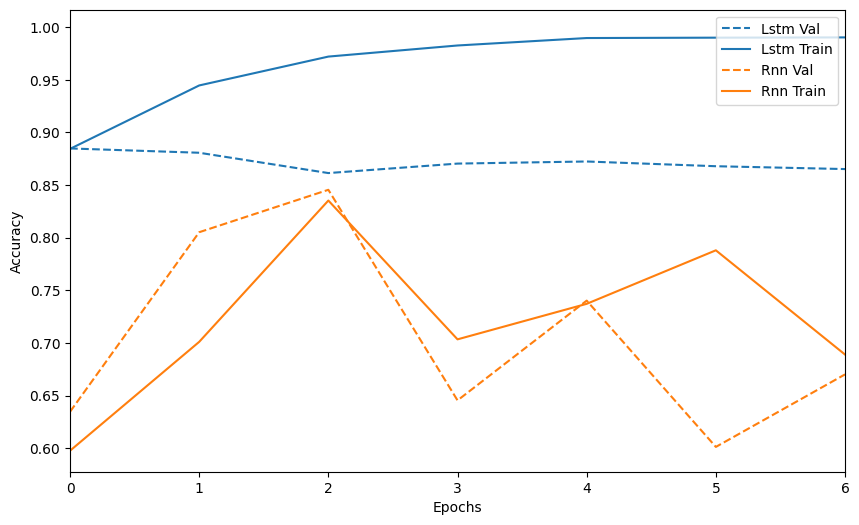

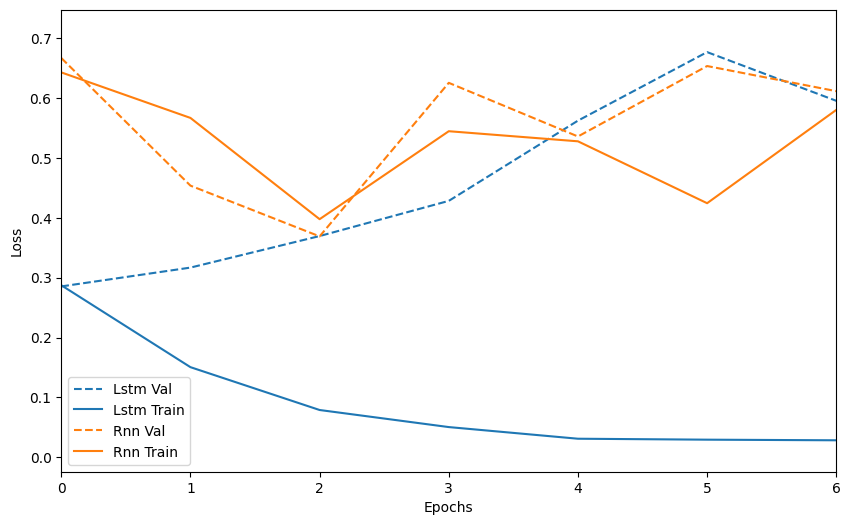

In [ ]:
import matplotlib.pyplot as plt

def plot_history(histories, key='accuracy'):
    plt.figure(figsize=(10, 6))
    for name, history in histories:
        val = plt.plot(history.epoch, history.history['val_'+key],
                       '--', label=name.title()+' Val')
        plt.plot(history.epoch, history.history[key], color=val[0].get_color(),
                 label=name.title()+' Train')

    plt.xlabel('Epochs')
    plt.ylabel(key.replace('_', ' ').title())
    plt.legend()
    plt.xlim([0, max(history.epoch)])

# Plot the accuracy
plot_history([('LSTM', lstm_history), ('RNN', rnn_history)])

# Plot the loss
plot_history([('LSTM', lstm_history), ('RNN', rnn_history)], key='loss')

In [ ]:
# Save the LSTM model
lstm_model.save('/content/drive/MyDrive/lstm_model.h5')  # Saves the model to Google Drive.

# Save the RNN model
rnn_model.save('/content/drive/MyDrive/rnn_model.h5')  # Saves the model to Google Drive.

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
